## Package Install

In [ ]:
### 필요한 패키지 설치
!pip install keras
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install statsmodels
!pip install openpyxl
!pip install xgboost
!pip install Boruta
!pip install asgl

## Main 1. Data Transformation Part

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import date

# FRED-MD 2016년 1월 vintage 데이터
data = pd.read_csv("2016-01.csv")

In [2]:
y1 = np.diff(np.log(data['CPIAUCSL']))[2:]
y2 = np.diff(np.log(data['PCEPI']))[2:]

data = data.drop(columns=['CPIAUCSL', 'PCEPI'])
tcode = data.iloc[0] # 첫 번째 행: Tcode
data = data.iloc[1:, :].reset_index(drop=True) # Tcode 행 제거 
tdata = data.iloc[2:, :].copy().reset_index(drop=True) # 최초 2 표본 제거(2차 차분 고려)

In [3]:
# 정상시계열 변환
for i in range(1, data.shape[1]):
    col = data.columns[i]
    code = int(tcode[i])

    if code == 1:
        tdata[col] = data.iloc[2:, i].values # 그대로

    elif code == 2:
        tdata[col] = data.iloc[1:, i].diff().iloc[1:].values # 1차 차분

    # tcode == 3 (2차 차분)에 해당하는 데이터는 없음

    elif code == 4:
        tdata[col] = np.log(data.iloc[2:, i].values) # log

    elif code == 5:
        tdata[col] = np.diff(np.log(data.iloc[1:, i].values)) # log 취한 뒤 1차 차분

    elif code == 6:
        tdata[col] = np.diff(np.diff(np.log(data.iloc[:, i].values))) # log 취한 뒤 2차 차분

    elif code == 7:
        ratio = data.iloc[1:, i].values / data.iloc[:-1, i].values 
        tdata[col] = np.diff(ratio) # 증가율의 1차 차분

In [4]:
tdata = tdata.iloc[:, 1:] # date 제거, 1960년 1월 ~ 2000년 12월  
Y = pd.concat([pd.Series(y1, name='CPI'), 
               pd.Series(y2, name='PCE'), 
               tdata.reset_index(drop=True)], axis=1)

# Medeiros et al.(2021) 데이터 확인 결과 1960년 2월부터 사용
Y = Y.iloc[:, 1:]

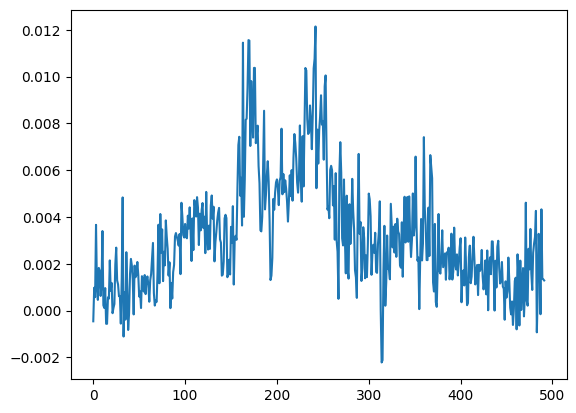

In [5]:
import matplotlib.pyplot as plt

inflation = Y.iloc[:,0]
plt.plot(inflation)

In [6]:
import random
import tensorflow as tf

# Random seed
np.random.seed(21)
random.seed(21)
tf.random.set_seed(21)

## Main 2. Forecasting Part

In [8]:
import ML_Functions as ml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
scaler_std = StandardScaler()

npred=132

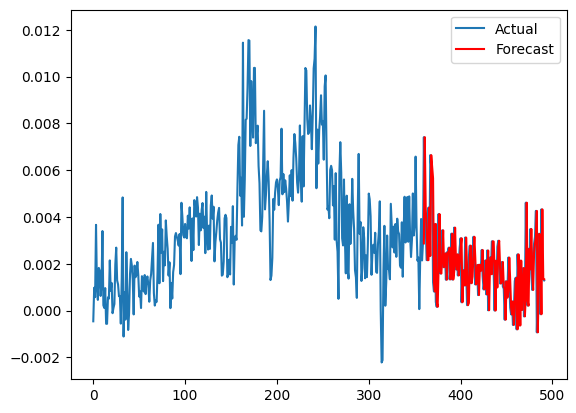

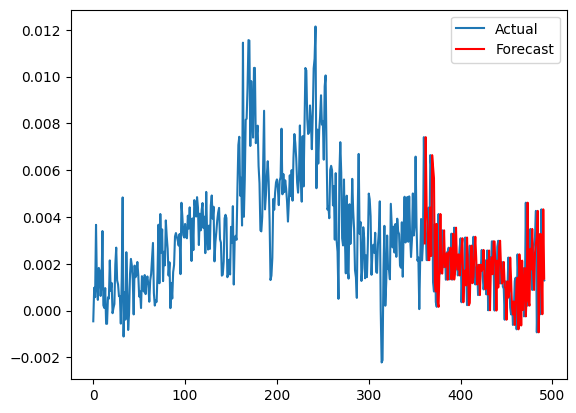

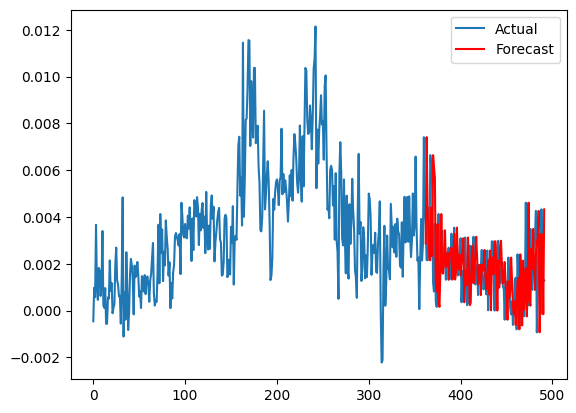

In [ ]:
# Random Walk
rw_1 = ml.rw_rolling_window(Y = Y, npred = npred, horizon = 1)
rw_2 = ml.rw_rolling_window(Y = Y, npred = npred, horizon = 2)
rw_3 = ml.rw_rolling_window(Y = Y, npred = npred, horizon = 3)

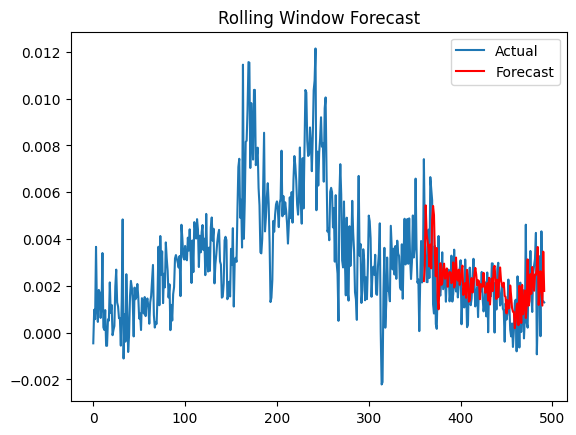

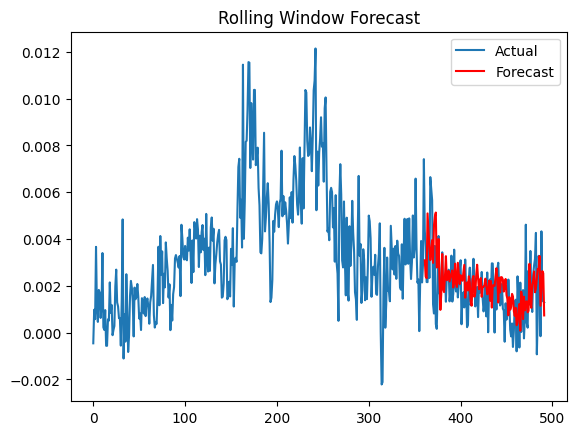

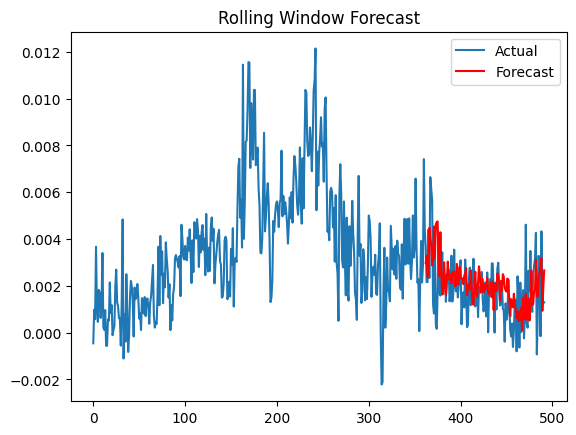

In [ ]:
## AR(4) Model ##
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
import statsmodels.api as sm

ar_1 = ml.ar_rolling_window(Y = Y, npred = npred, lag = 4, horizon = 1)
ar_2 = ml.ar_rolling_window(Y = Y, npred = npred, lag = 4, horizon = 2)
ar_3 = ml.ar_rolling_window(Y = Y, npred = npred, lag = 4, horizon = 3)

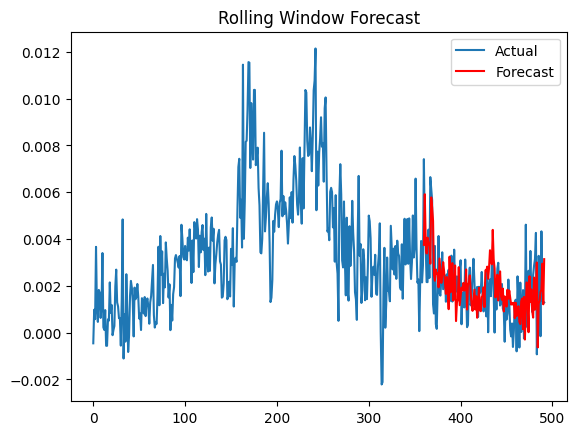

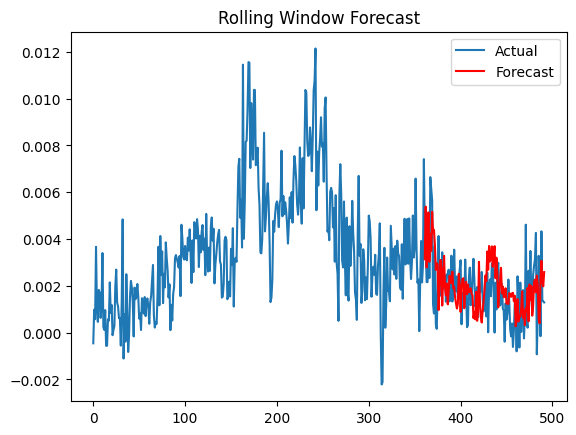

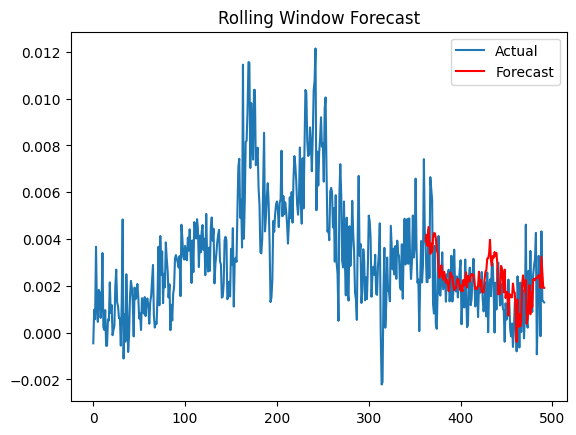

In [14]:
## Ridge Regression, cross-validation 사용 ##
import warnings
warnings.filterwarnings("ignore", category=UserWarning) ## 경고 문구가 과도하게 뜨는 것을 방지하기 위한 코드

ridge_1 = ml.shrinkage_cv_rolling_window(Y = Y, npred = npred, horizon = 1, alpha=0)
ridge_2 = ml.shrinkage_cv_rolling_window(Y = Y, npred = npred, horizon = 2, alpha=0)
ridge_3 = ml.shrinkage_cv_rolling_window(Y = Y, npred = npred, horizon = 3, alpha=0)

In [ ]:
## LASSO ##
from sklearn.linear_model import ElasticNetCV

lasso_1 = ml.shrinkage_cv_rolling_window(Y = Y, npred = npred, horizon = 1, alpha=1)
lasso_2 = ml.shrinkage_cv_rolling_window(Y = Y, npred = npred, horizon = 2, alpha=1)
lasso_3 = ml.shrinkage_cv_rolling_window(Y = Y, npred = npred, horizon = 3, alpha=1)

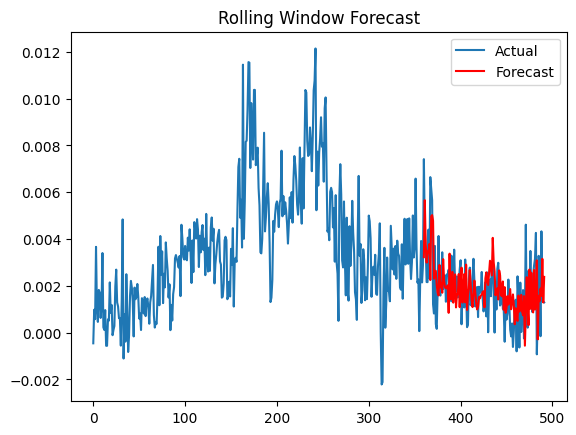

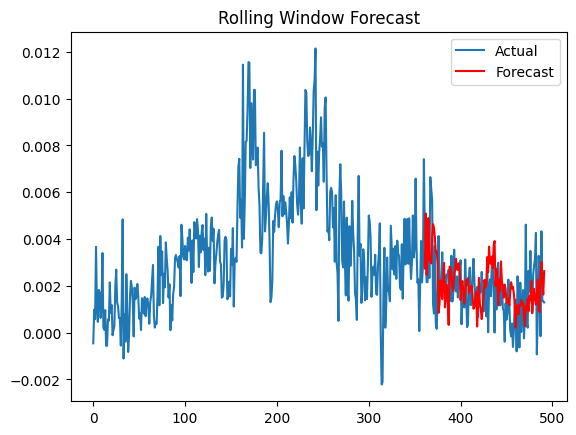

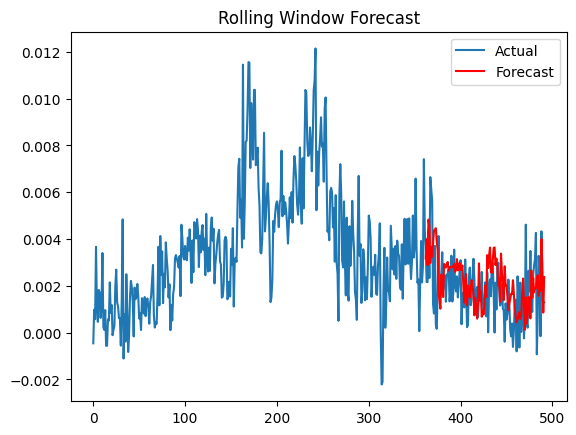

In [ ]:
## Elastic Net ##
elasticnet_1 = ml.shrinkage_cv_rolling_window(Y = Y, npred = npred, horizon = 1, alpha=0.5)
elasticnet_2 = ml.shrinkage_cv_rolling_window(Y = Y, npred = npred, horizon = 2, alpha=0.5)
elasticnet_3 = ml.shrinkage_cv_rolling_window(Y = Y, npred = npred, horizon = 3, alpha=0.5)

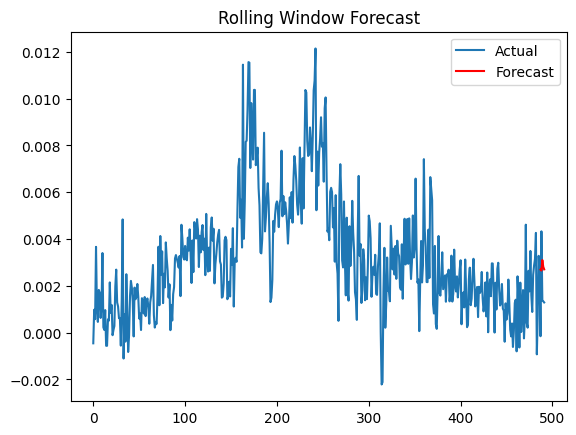

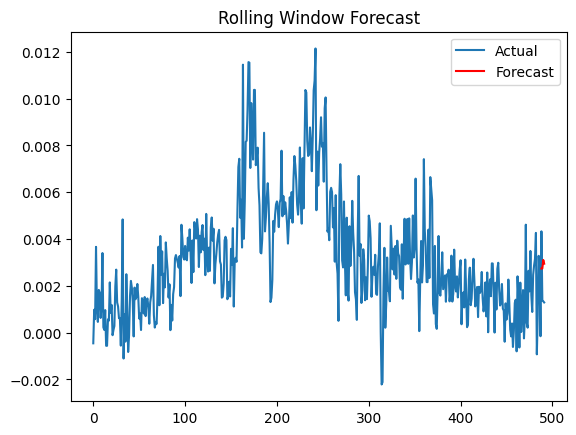

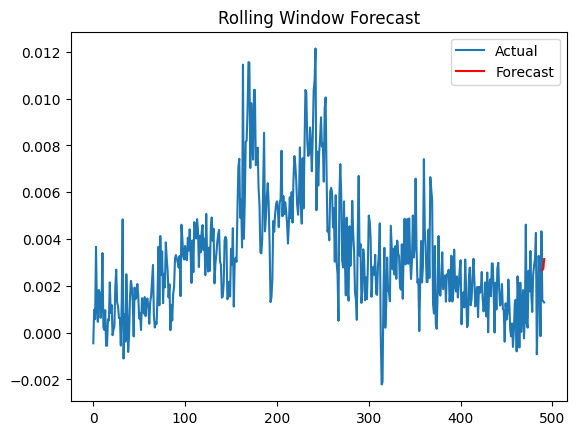

In [10]:
## Complete Subset Regression (CSR) ##
csr_1 = ml.csr_rolling_window(Y = Y, npred = npred, horizon = 1)
csr_2 = ml.csr_rolling_window(Y = Y, npred = npred, horizon = 2)
csr_3 = ml.csr_rolling_window(Y = Y, npred = npred, horizon = 3)

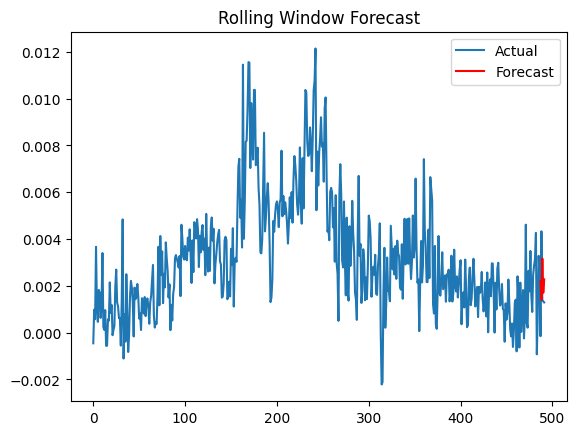

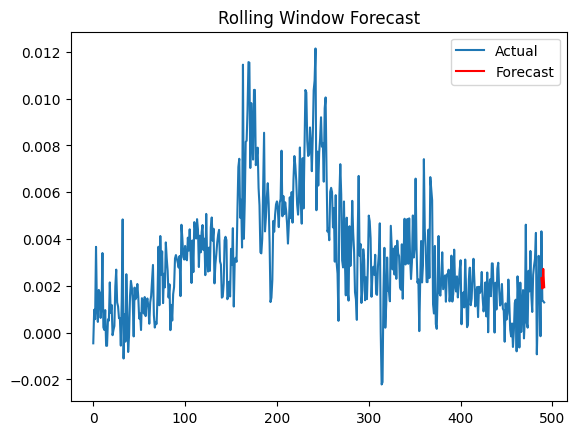

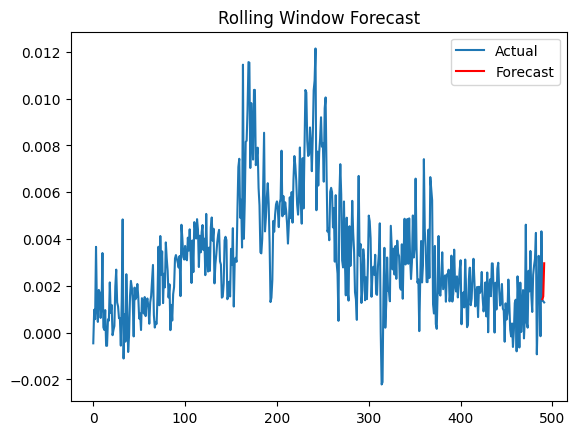

In [15]:
## Target Factors ##
tfact_1 = ml.tfact_rolling_window(Y, npred = npred, horizon = 1)
tfact_2 = ml.tfact_rolling_window(Y, npred = npred, horizon = 2)
tfact_3 = ml.tfact_rolling_window(Y, npred = npred, horizon = 3)

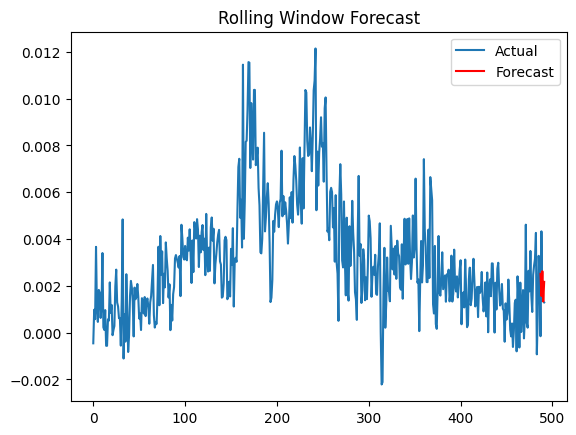

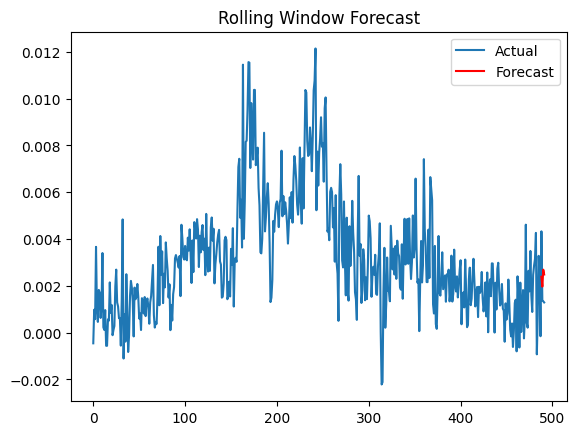

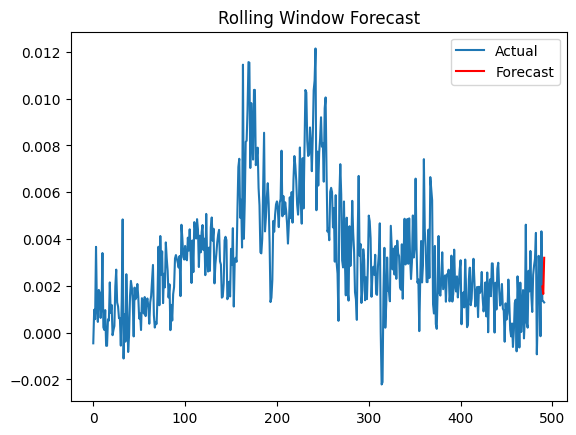

In [ ]:
## Random Forest (RF) ##
from sklearn.ensemble import RandomForestRegressor

rf_1 = ml.rf_rolling_window(Y, npred = npred, horizon = 1)
rf_2 = ml.rf_rolling_window(Y, npred = npred, horizon = 2)
rf_3 = ml.rf_rolling_window(Y, npred = npred, horizon = 3)

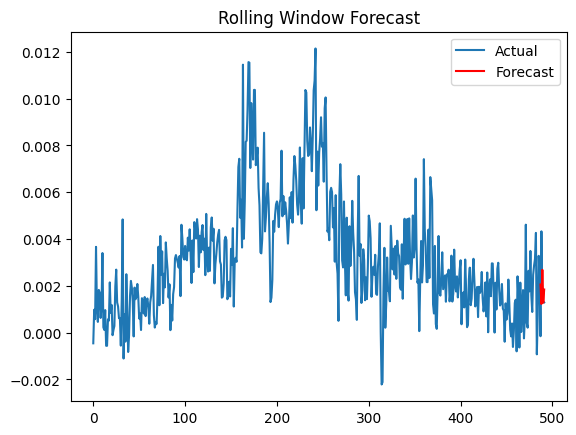

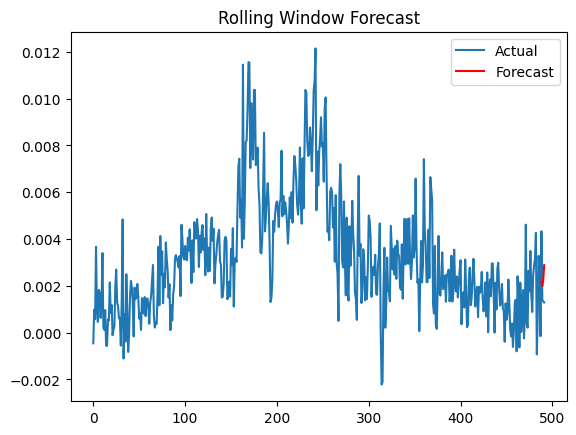

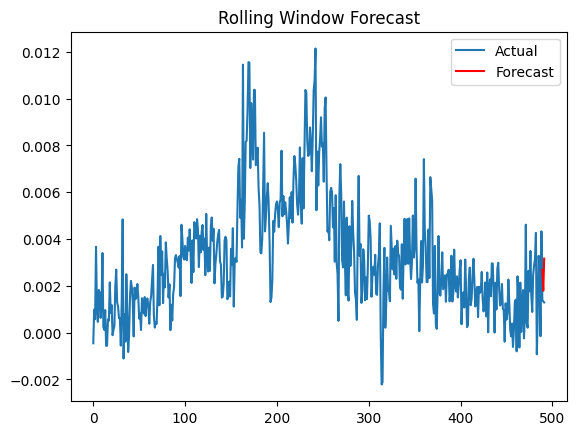

In [ ]:
## XGBoost ##
import xgboost as xgb

xgb_1 = ml.xgb_rolling_window(Y, npred, 1)
xgb_2 = ml.xgb_rolling_window(Y, npred, 2)
xgb_3 = ml.xgb_rolling_window(Y, npred, 3)

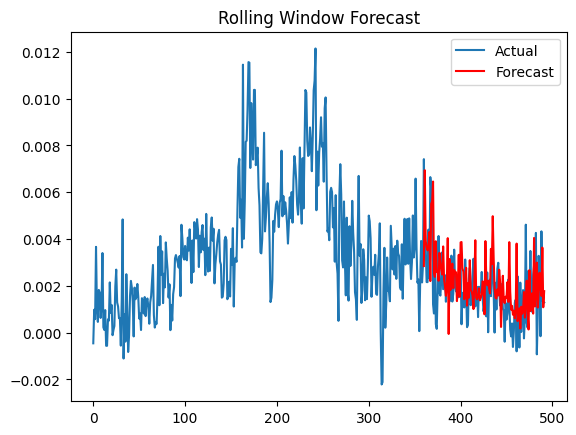

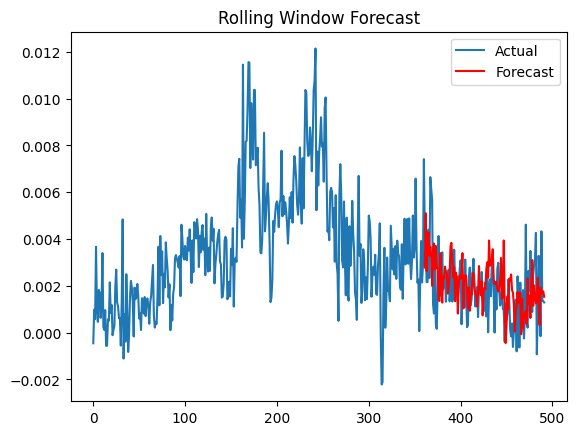

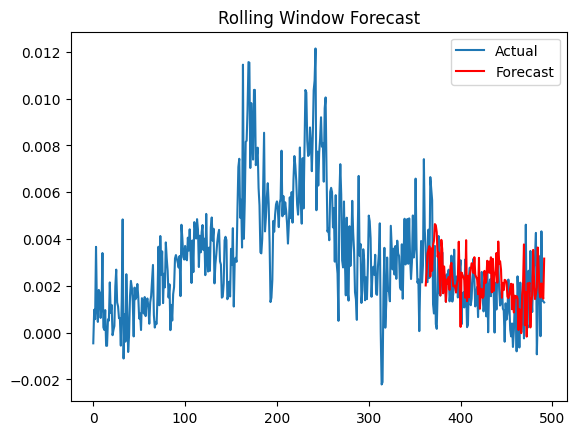

In [ ]:
## Neural Networks(Deep Learning) ##
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

nn_1 = ml.nn_rolling_window(Y, npred = npred, horizon = 1)
nn_2 = ml.nn_rolling_window(Y, npred = npred, horizon = 2)
nn_3 = ml.nn_rolling_window(Y, npred = npred, horizon = 3)

1/1 [==============================] - 1s 631ms/step


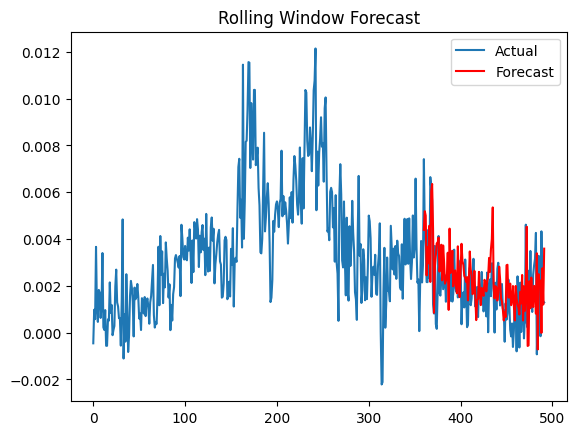

1/1 [==============================] - 1s 962ms/step


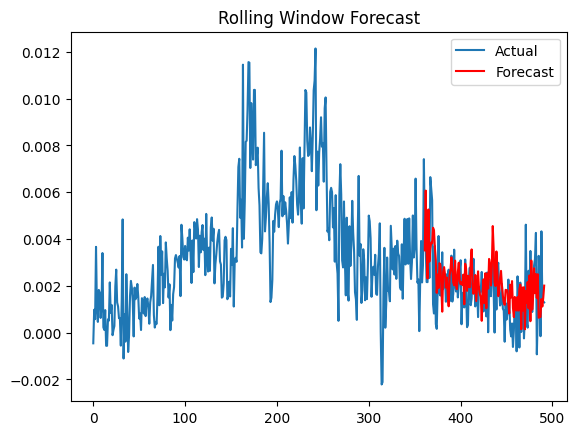

1/1 [==============================] - 1s 668ms/step


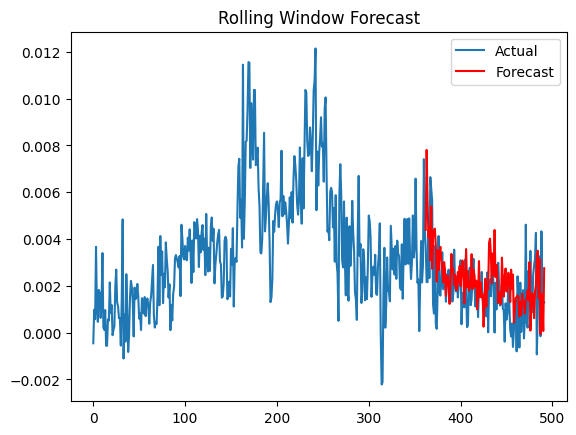

In [ ]:
## LSTM ##
from tensorflow.keras.layers import LSTM, Dense

lstm_1 = ml.rolling_window_lstm_single(Y, npred = npred, horizon = 1)
lstm_2 = ml.rolling_window_lstm_single(Y, npred = npred, horizon = 2)
lstm_3 = ml.rolling_window_lstm_single(Y, npred = npred, horizon = 3)

## Main 3. Predicted Value and Loss Table

In [ ]:
model_preds = {
    "rw": [rw_1["pred"], rw_2["pred"], rw_3["pred"]],
    "ar": [ar_1["pred"], ar_2["pred"], ar_3["pred"]],
    "ridge": [ridge_1["pred"], ridge_2["pred"], ridge_3["pred"]],
    "lasso": [lasso_1["pred"], lasso_2["pred"], lasso_3["pred"]],
    "elasticnet": [elasticnet_1["pred"], elasticnet_2["pred"], elasticnet_3["pred"]],
    "csr": [csr_1["pred"], csr_2["pred"], csr_3["pred"]],
    "tfact": [tfact_1["pred"], tfact_2["pred"], tfact_3["pred"]],
    "rf": [rf_1["pred"], rf_2["pred"], rf_3["pred"]],
    "xgb": [xgb_1["pred"], xgb_2["pred"], xgb_3["pred"]],
    "nn": [nn_1["pred"], nn_2["pred"], nn_3["pred"]],
    "lstm": [lstm_1["pred"], lstm_2["pred"], lstm_3["pred"]],
}

model_forecasts = {}
for model, preds in model_preds.items():
    mat = np.full((npred, 3), np.nan)
    for h in range(3):
        horizon_len = npred - h
        mat[-horizon_len:, h] = preds[h][-horizon_len:]
    df = pd.DataFrame(mat, columns=["h=1", "h=2", "h=3"])
    model_forecasts[f"{model}_d_pred_df"] = df

PRED = pd.concat(model_forecasts.values(), axis=1)


In [27]:
### Horizon에 따라 결과를 구분하여 저장
PRED_1 = PRED.iloc[:, [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]]
PRED_2 = PRED.iloc[:, [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31]]
PRED_3 = PRED.iloc[:, [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32]]

In [9]:
### 실제값을 저장
REAL = Y.iloc[:, 0][-npred:]

In [29]:
### 실제값과 예측치의 차이를 저장하기
# LOSS1: Squared error
LOSS1_1 = (PRED_1.reset_index(drop=True) - REAL.iloc[-npred:].reset_index(drop=True).values.reshape(-1, 1)) ** 2
LOSS1_2 = (PRED_2.iloc[-131:, :].reset_index(drop=True) - REAL.iloc[-131:].reset_index(drop=True).values.reshape(-1, 1)) ** 2
LOSS1_3 = (PRED_3.iloc[-130:, :].reset_index(drop=True) - REAL.iloc[-130:].reset_index(drop=True).values.reshape(-1, 1)) ** 2

# LOSS2: Absolute error
LOSS2_1 = (PRED_1.reset_index(drop=True) - REAL.iloc[-npred:].reset_index(drop=True).values.reshape(-1, 1)).abs()
LOSS2_2 = (PRED_2.iloc[-131:, :].reset_index(drop=True) - REAL.iloc[-131:].reset_index(drop=True).values.reshape(-1, 1)).abs()
LOSS2_3 = (PRED_3.iloc[-130:, :].reset_index(drop=True) - REAL.iloc[-130:].reset_index(drop=True).values.reshape(-1, 1)).abs()

In [30]:
### 모형에 따라 각 열의 이름 지정
column_names = [
    "RW", "AR", "Ridge", "LASSO", "Elasticnet","CSR","Target factor","Random forest",
    "XGBoost", "Neural Net", "LSTM"
]
horizons = ["1m", "2m", "3m"]

LOSS1_1.columns = column_names[:LOSS1_1.shape[1]]
LOSS1_2.columns = column_names[:LOSS1_2.shape[1]]
LOSS1_3.columns = column_names[:LOSS1_3.shape[1]]

LOSS2_1.columns = column_names[:LOSS2_1.shape[1]]
LOSS2_2.columns = column_names[:LOSS2_2.shape[1]]
LOSS2_3.columns = column_names[:LOSS2_3.shape[1]]


In [31]:
RMSE = pd.DataFrame(index=column_names, columns=horizons)
MAE = pd.DataFrame(index=column_names, columns=horizons)

def compute_metrics(pred_df, real):
    rmse = np.sqrt(((pred_df.subtract(real, axis=0)) ** 2).mean())
    mae = (pred_df.subtract(real, axis=0).abs()).mean()
    return rmse, mae

rmse1, mae1 = compute_metrics(PRED_1, REAL)
rmse2, mae2 = compute_metrics(PRED_2, REAL)
rmse3, mae3 = compute_metrics(PRED_3, REAL)

In [32]:
RMSE["1 month"] = rmse1.values
RMSE["2 month"] = rmse2.values
RMSE["3 month"] = rmse3.values

MAE["1 month"] = mae1.values
MAE["2 month"] = mae2.values
MAE["3 month"] = mae3.values

## Main 4. US inflation test

In [11]:
from statsmodels.stats.sandwich_covariance import cov_hac, cov_white_simple
from scipy.stats import norm
from itertools import combinations
from scipy.stats import t

### GW test

In [12]:
def run_gw_test(model_pred, benchmark_pred, real, npred, horizons):
    stat = [np.nan] * len(horizons)
    pval = [np.nan] * len(horizons)
    for idx, h in enumerate(horizons):
        if h == 1:
            gw = ml.gw_test(model_pred[:, h - 1], benchmark_pred[:, h - 1], real, tau=h, T=npred, method="NeweyWest")
        else:
            gw = ml.gw_test(model_pred[h - 1:, h - 1], benchmark_pred[h - 1:, h - 1], real[h - 1:], tau=h, T=npred - h + 1, method="NeweyWest")
        stat[idx] = gw["statistic"]
        pval[idx] = gw["p_value"]
    return {"stat": stat, "pval": pval}

In [13]:
num_models = PRED.shape[1] // 3
model_names = [f"model_{i+1}" for i in range(num_models)]
horizons = ["h=1", "h=2", "h=3"]

multi_cols = pd.MultiIndex.from_product([model_names, horizons], names=["Model", "Horizon"])
PRED.columns = multi_cols

model_dfs = {
    model: PRED.loc[:, model].to_numpy()
    for model in model_names
}

benchmark_model = "model_1" ## Random walk model

results = {
    model.upper(): run_gw_test(model_dfs[model], model_dfs[benchmark_model], REAL.to_numpy(), npred, [1, 2, 3])
    for model in model_names if model != benchmark_model
}

In [15]:
gw_stat = pd.DataFrame({k: v["stat"] for k, v in results.items()}).T
gw_pval = pd.DataFrame({k: v["pval"] for k, v in results.items()}).T

column_names = [
    "RW", "AR", "Ridge", "LASSO", "Elasticnet","CSR","Target factor","Random forest",
    "XGBoost", "Neural Net", "LSTM"
]

model_names_no_benchmark = column_names[1:]

gw_stat.index = model_names_no_benchmark
gw_pval.index = model_names_no_benchmark

gw_stat.columns = gw_pval.columns = [f"h={h}" for h in [1, 2, 3]]
gw_stat = gw_stat.round(2)
gw_pval = gw_pval.round(3)

### MCS test

In [ ]:
mcs_rmse_1 = ml.MCSprocedure_py(LOSS1_1, alpha=0.5, B=1000, verbose=True, statistic="Tmax")
mcs_rmse_2 = ml.MCSprocedure_py(LOSS1_2, alpha=0.5, B=1000, verbose=True, statistic="Tmax")
mcs_rmse_3 = ml.MCSprocedure_py(LOSS1_3, alpha=0.5, B=1000, verbose=True, statistic="Tmax")

Model RW eliminated at p = 0.0310
Model CSR eliminated at p = 0.0500
Model Neural Net eliminated at p = 0.0240
Model LSTM eliminated at p = 0.0960
Model AR eliminated at p = 0.1040
Model RW eliminated at p = 0.0110
Model CSR eliminated at p = 0.0050
Model Elasticnet eliminated at p = 0.2750
Model CSR eliminated at p = 0.0400


In [41]:
print(mcs_rmse_1['SSM'])
print(mcs_rmse_2['SSM'])
print(mcs_rmse_3['SSM'])

                    v_M       v_R      Loss
Random forest -1.707649 -0.264197  0.000002
XGBoost       -1.251108  0.264197  0.000002
Ridge          0.440657  1.329734  0.000002
LASSO          0.857135  1.568443  0.000002
Target factor  0.834320  1.518904  0.000002
Elasticnet     1.185732  1.599449  0.000002
                    v_M       v_R      Loss
AR            -0.841717 -0.094479  0.000002
LSTM          -0.703895  0.094479  0.000002
XGBoost       -0.287166  0.397315  0.000002
LASSO         -0.343679  0.447414  0.000002
Random forest -0.238886  0.611271  0.000002
Ridge          0.493001  1.039100  0.000002
Target factor  0.731047  1.093961  0.000002
Neural Net     1.033099  1.245618  0.000002
                    v_M       v_R      Loss
AR            -1.922698 -0.255156  0.000002
LASSO         -3.044807  0.255156  0.000002
Ridge         -1.977432  0.439296  0.000002
Target factor -1.525406  0.758875  0.000002
XGBoost       -0.451162  1.968904  0.000002
Elasticnet    -0.339859  2.94235

In [ ]:
mcs_mae_1 = ml.MCSprocedure_py(LOSS2_1, alpha=0.5, B=1000, verbose=True, statistic="Tmax")
mcs_mae_2 = ml.MCSprocedure_py(LOSS2_2, alpha=0.5, B=1000, verbose=True, statistic="Tmax")
mcs_mae_3 = ml.MCSprocedure_py(LOSS2_3, alpha=0.5, B=1000, verbose=True, statistic="Tmax")

Model CSR eliminated at p = 0.0600
Model RW eliminated at p = 0.0540
Model Neural Net eliminated at p = 0.0210
Model LSTM eliminated at p = 0.1380
Model AR eliminated at p = 0.1630
Model RW eliminated at p = 0.0050
Model CSR eliminated at p = 0.0160
Model Elasticnet eliminated at p = 0.3000
Model CSR eliminated at p = 0.0060


In [43]:
print(mcs_mae_1['SSM'])
print(mcs_mae_2['SSM'])
print(mcs_mae_3['SSM'])

                    v_M       v_R      Loss
Random forest -1.325388 -0.288229  0.001070
XGBoost       -1.086766  0.288229  0.001079
LASSO          0.153207  1.021451  0.001118
Target factor  0.227442  1.040647  0.001122
Elasticnet     1.116645  1.351565  0.001149
Ridge          0.973462  1.302450  0.001149
                    v_M       v_R      Loss
AR            -0.933776 -0.191767  0.001088
LSTM          -0.654322  0.191767  0.001102
XGBoost       -0.754144  0.224916  0.001102
LASSO         -0.866658  0.260842  0.001104
Random forest  0.377888  1.136144  0.001143
Target factor  0.801400  1.419558  0.001160
Neural Net     0.849970  1.148808  0.001166
Ridge          1.255732  1.798564  0.001181
                    v_M       v_R      Loss
LASSO         -3.036591 -0.294549  0.001044
AR            -1.807663  0.294549  0.001061
Ridge         -1.319156  0.974659  0.001091
Target factor -0.848097  1.067530  0.001108
XGBoost        0.052303  1.932963  0.001147
Elasticnet     0.267300  3.28609